## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# For display
pd.set_option('display.max_columns', None)

In [2]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

## Loading Datasets

In [3]:
full_df =pd.read_csv(r"C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\processed_patient_segmentation\full_df.csv")
drop_df =pd.read_csv(r"C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\raw\dropout_flags.csv")
drop_df = drop_df.set_index('patient_id')

In [4]:
# -- merge drop_df with full_df
pred_df = pd.merge(full_df, drop_df, on='patient_id', how='left')

pred_df.head()

,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,age_group,signup_month,signup_dayofweek,bmi_category,has_chronic_cond,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta,home_adherence_mean,satisfaction_mean,dropout,dropout_week
0,1,29,Male,23.9,False,No chronic,Knee,2025-04-27 00:12:44,Insurance,True,6,Public,19-35,4,Sunday,Normal,0,20,41.750000,1,12,2.150000,-0.263158,77.750000,6.500000,False,NaN
1,2,68,Female,31.7,True,No chronic,Shoulder,2024-11-28 00:12:44,Insurance,False,3,Public,55+,11,Thursday,Obese,0,8,33.875000,1,11,2.250000,-0.571429,61.625000,7.000000,False,NaN
2,3,64,Male,27.5,False,No chronic,Hip,2024-10-10 00:12:44,GP,True,5,Public,55+,10,Thursday,Overweight,0,17,41.470588,1,12,2.470588,-0.312500,73.705882,5.941176,False,NaN
3,4,41,Female,26.1,False,No chronic,Back,2024-12-12 00:12:44,GP,True,2,Private-Premium,36-55,12,Thursday,Overweight,0,17,47.588235,1,12,2.000000,-0.312500,69.764706,6.647059,False,NaN
4,5,22,Female,21.3,False,No chronic,Shoulder,2025-03-28 00:12:44,Insurance,True,4,Private-Basic,19-35,3,Friday,Normal,0,12,33.833333,1,10,2.333333,-0.363636,73.666667,6.416667,False,NaN


## Data Cleaning and Transformations

In [5]:
# --- Data cleaning

# drop irrelevant or highly correlated features
pred_df = pred_df.drop(columns=['dropout_week','patient_id','signup_dayofweek',
                                'chronic_cond','mean_pain_delta',
                                'age','bmi','first_week','last_week'], errors='ignore')


# Grouping into 'Public' and 'Private'
pred_df['insurance_type'] = pred_df['insurance_type'].replace({
    'Private-Premium': 'Private',
    'Private-Basic': 'Private',
    'Private-Top-Up': 'Private'
    })

pred_df['referral_source'] = pred_df['referral_source'].replace({
    'Insurance': 'Professional',
    'GP': 'Professional',
    'Hospital': 'Professional',
    'Self-Referral': 'Self'
})


# bmi
bmi_mapping = {
    'Underweight': 0,
    'Normal': 1,
    'Overweight': 2,
    'Obese': 3
}

# Apply mapping
pred_df['bmi_category'] = pred_df['bmi_category'].map(bmi_mapping)


# age_group
age_mapping = {
    '0-18': 0,
    '19-35': 1,
    '36-55': 2,
    '55+': 3
}

# Apply mapping
pred_df['age_group'] = pred_df['age_group'].map(age_mapping)                                

## Data Labeling

In [6]:
from sklearn.preprocessing import LabelEncoder
# -------------------------------
# Feature Groups
num_features = [
    "n_sessions", "avg_session_duration",
    "satisfaction_mean", "home_adherence_mean"
    
]
	
label = [
    "gender", "smoker", "referral_source",
    "consent", "insurance_type",  
    "bmi_category", "has_chronic_cond"
]

high_card_cat = ["injury_type"]

# -------------------------------
# Manual Label Encoding
label_encoders = {}
for col in label:
    le = LabelEncoder()
    pred_df[col] = le.fit_transform(pred_df[col])
    label_encoders[col] = le

    # Print the mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col}: {mapping}")

# -------------------------------
# Preprocessing Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

high_card_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# -------------------------------
# Full Column Transformer
ml_preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("high_cat", high_card_pipeline, high_card_cat),
    ("label", "passthrough", label)  # passthrough manually encoded categorical columns
])

gender: {'Female': 0, 'Male': 1}
smoker: {False: 0, True: 1}
referral_source: {'Professional': 0, 'Self': 1}
consent: {False: 0, True: 1}
insurance_type: {'Private': 0, 'Public': 1}
bmi_category: {0: 0, 1: 1, 2: 2, 3: 3}
has_chronic_cond: {0: 0, 1: 1}


## Model Building

In [7]:
# Split  data
x = pred_df.drop(columns=["dropout","signup_date"], axis=1)
y = pred_df["dropout"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# check for class imbalance

print(y.value_counts())
print("\nProportions:\n")
print(y.value_counts(normalize=True))

dropout
False    4919
True       81
Name: count, dtype: int64

Proportions:

dropout
False    0.9838
True     0.0162
Name: proportion, dtype: float64


In [9]:
# models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", ml_preprocessor),
        ("smote", SMOTETomek(random_state=42)),
        ("classifier", model)
    ])

    # Train
    pipeline.fit(x_train, y_train)

    # Predict
    y_pred = pipeline.predict(x_test)
    y_proba = pipeline.predict_proba(x_test)[:, 1]

    # Evaluation
    roc = roc_auc_score(y_test, y_proba)
    cv = cross_val_score(pipeline, x, y, cv=5, scoring="f1").mean()

    print(f"\n📊 Model: {name}")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc:.4f}")
    print(f"Cross-Validated F1 Score: {cv:.4f}")


📊 Model: Logistic Regression
Classification Report:

              precision    recall  f1-score   support

       False       1.00      0.81      0.89       984
        True       0.07      0.88      0.13        16

    accuracy                           0.81      1000
   macro avg       0.53      0.84      0.51      1000
weighted avg       0.98      0.81      0.88      1000

ROC AUC Score: 0.9224
Cross-Validated F1 Score: 0.1244

📊 Model: Random Forest
Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       984
        True       0.17      0.06      0.09        16

    accuracy                           0.98      1000
   macro avg       0.58      0.53      0.54      1000
weighted avg       0.97      0.98      0.98      1000

ROC AUC Score: 0.8692
Cross-Validated F1 Score: 0.0411

📊 Model: XGBoost
Classification Report:

              precision    recall  f1-score   support

       False       0.98      0.99    

### Hyperparameter Tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define param grids
param_distributions = {
    "Logistic Regression": {
        "classifier__C": uniform(0.01, 10),
        "classifier__penalty": ["l2"],
        "classifier__solver": ["lbfgs", "liblinear"],
    },

    "Random Forest": {
        "classifier__n_estimators": randint(50, 200),
        "classifier__max_depth": [None, 5, 10, 20],
        "classifier__min_samples_split": randint(2, 10),
        "classifier__min_samples_leaf": randint(1, 5),
    },

    "XGBoost": {
        "classifier__n_estimators": randint(50, 200),
        "classifier__max_depth": randint(3, 10),
        "classifier__learning_rate": uniform(0.01, 0.3),
        "classifier__subsample": uniform(0.5, 0.5),
        "classifier__colsample_bytree": uniform(0.5, 0.5),
    }
}

In [11]:
best_models = {}

for name, model in models.items():
    print(f"\n🔍 Tuning: {name}")

    pipeline = Pipeline([
        ("preprocessing", ml_preprocessor),
        ("smote", SMOTETomek(random_state=42)),
        ("classifier", model)
    ])

    # Setup RandomizedSearchCV
    search = RandomizedSearchCV(
        pipeline,
        param_distributions[name],
        n_iter=20,  # try 20 random combinations
        cv=5,
        scoring="f1",
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(x_train, y_train)

    # Best model
    best_models[name] = search.best_estimator_

    # Predict on test set
    y_pred = search.predict(x_test)
    y_proba = search.predict_proba(x_test)[:, 1]

    # Evaluate
    print("Best Parameters:", search.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Best CV F1 Score: {search.best_score_:.4f}")



🔍 Tuning: Logistic Regression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__C': 0.017787658410143285, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.79      0.88       984
        True       0.06      0.88      0.12        16

    accuracy                           0.79      1000
   macro avg       0.53      0.83      0.50      1000
weighted avg       0.98      0.79      0.87      1000

ROC AUC Score: 0.9247
Best CV F1 Score: 0.1278

🔍 Tuning: Random Forest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.89      0.94       984
        True      

### Feature Importance

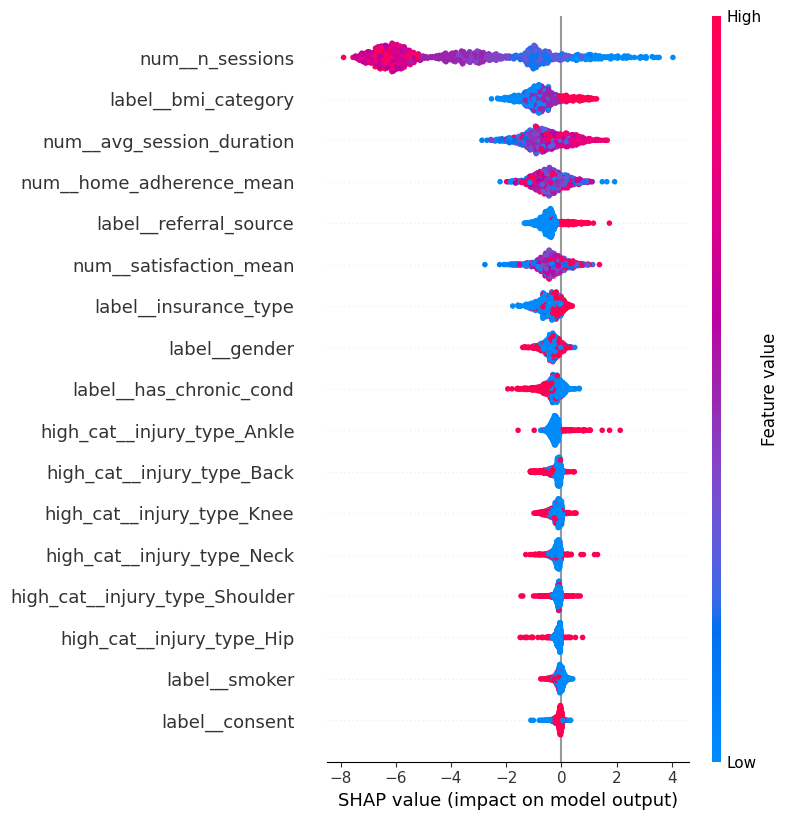

In [12]:
# Fit only on the training data
ml_preprocessor.fit(x_train)

# Transform both train and test sets
x_train_transformed = ml_preprocessor.transform(x_train)
x_test_transformed = ml_preprocessor.transform(x_test)

# This only works if all transformers support get_feature_names_out
feature_names = ml_preprocessor.get_feature_names_out()

x_train_transformed = pd.DataFrame(x_train_transformed, columns=feature_names)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=feature_names)

import shap

# For tree-based models
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(x_test_transformed)

# summary bar
shap.summary_plot(shap_values, x_test_transformed)